There are a lot of survival tools in python. Let's develop some helper functions for a popular library lifelines

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from matplotlib import style
from tqdm.auto import tqdm

/Users/danielokeeffe/opt/miniconda3/envs/causal_ml_py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# Additional imports
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [2]:
# Set pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [3]:
# Set plot style
style.use('fivethirtyeight')

In [4]:
# initialize tqdm for pandas
tqdm.pandas()

In [5]:
df = pd.read_csv('../../../data/job_retention.csv')

In [6]:
df.head()

,gender,field,level,sentiment,intention,left,month
0,M,Public/Government,High,3,8,1,1
1,F,Finance,Low,8,4,0,12
2,M,Education and Training,Medium,7,7,1,5
3,M,Finance,Low,8,4,0,12
4,M,Finance,High,7,6,1,1


The example dataset is

1. gender = gender of individual

2. field = field of employment that they worked in at the beginning of the study

3. level = the level of the position at their organization at the beginning of the study (can be low, medium, high)

4. sentiment = the sentiment score reported on a scale of 1 to 10 at the beginning of the study. 1 indicates extemely negative while 10 indicates extremely positive

5. left = binary variable indicating whether or not the individual had left their job as of the last follow up

6. month = month of the last follow up

In [7]:
df['month'].describe()

count    3770.000000
mean        9.481432
std         3.429741
min         1.000000
25%         7.000000
50%        12.000000
75%        12.000000
max        12.000000
Name: month, dtype: float64

We follow up every month and define 'survival' as 'remaining in substantially the same job'. We regard month 0 as the starting point, and we follow up in each months 1 through 12. For a given month i, we define the survival rate as:

$$ S_{i} = S_{i - 1} \left ( 1 - \frac{l_{i}}{n_{i}} \right) $$

Where $l_{i}$ is the number of people reported as left in month i, $n_{i}$ is the number of people still in substantially the same job after month $i - 1$ and we define $S_{0} = 1$. 

In [10]:
kmf = KaplanMeierFitter()
kmf = kmf.fit(df['month'], event_observed=df['left'])

<AxesSubplot: xlabel='timeline'>

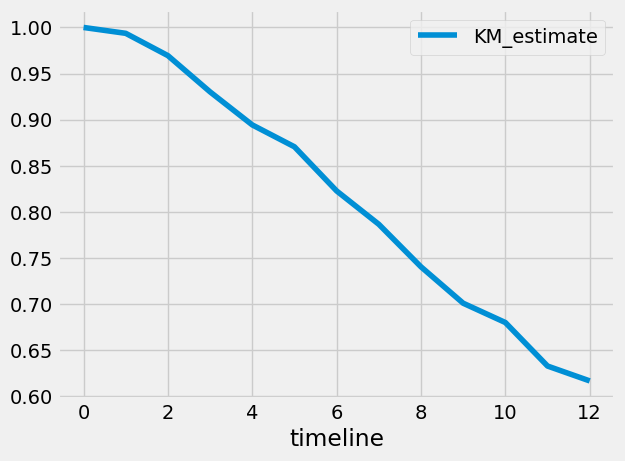

In [11]:
kmf.survival_function_.plot()

<AxesSubplot: xlabel='timeline'>

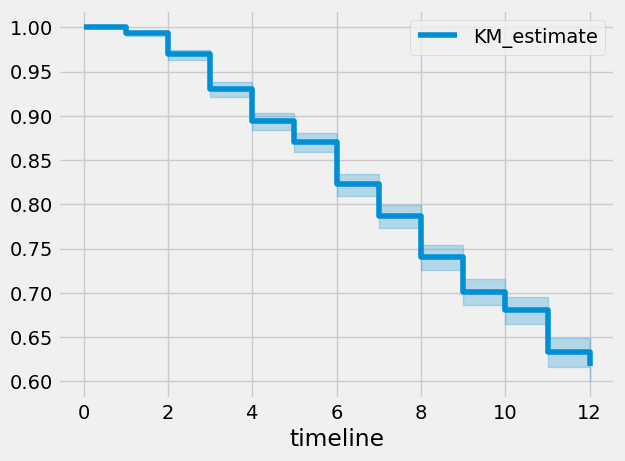

In [12]:
kmf.plot_survival_function()

In [13]:
# Why?
kmf.median_survival_time_

inf

In [14]:
# Can we segment the population on sentiment? i.e. does sentiment play a role in survival likelihood? 
df.head()

,gender,field,level,sentiment,intention,left,month
0,M,Public/Government,High,3,8,1,1
1,F,Finance,Low,8,4,0,12
2,M,Education and Training,Medium,7,7,1,5
3,M,Finance,Low,8,4,0,12
4,M,Finance,High,7,6,1,1


In [16]:
high_sentiment = (df['sentiment'] >= 7)

Text(0.5, 1.0, 'Survival by sentiment')

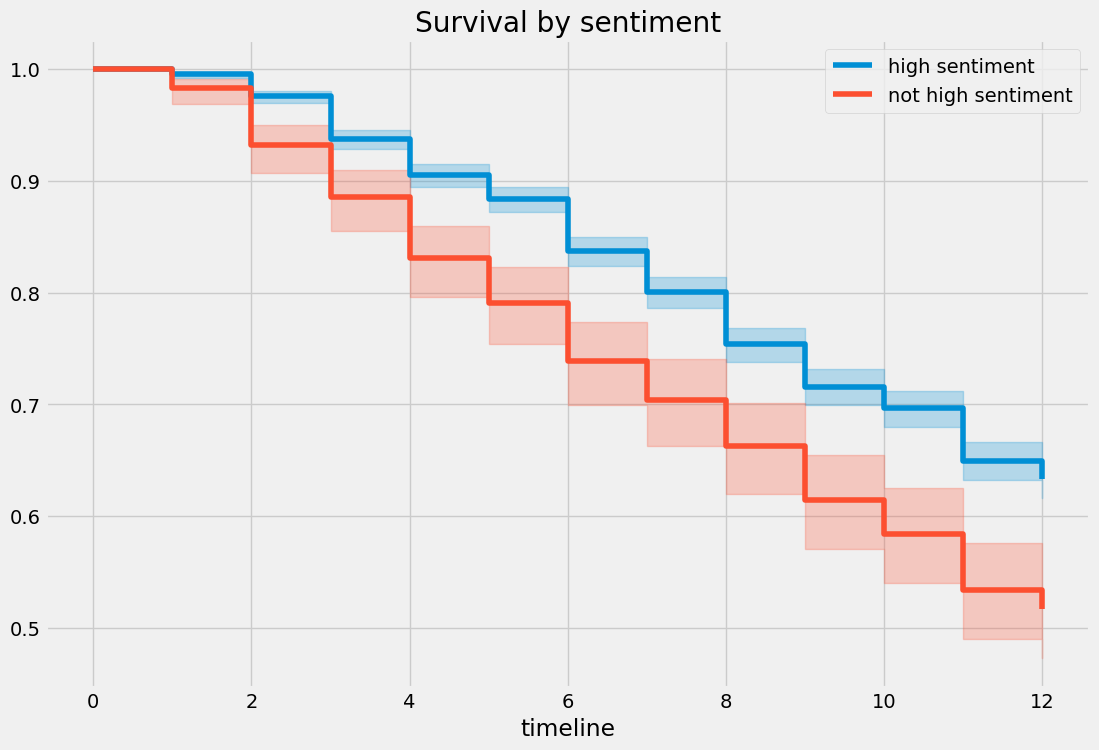

In [19]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

kmf.fit(df[high_sentiment]['month'], event_observed=df[high_sentiment]['left'], label='high sentiment')
kmf.plot_survival_function(ax=ax)

kmf.fit(df[~high_sentiment]['month'], event_observed=df[~high_sentiment]['left'], label='not high sentiment')
kmf.plot_survival_function(ax=ax)

plt.title('Survival by sentiment')

Text(0.5, 1.0, 'Survival by sentiment')

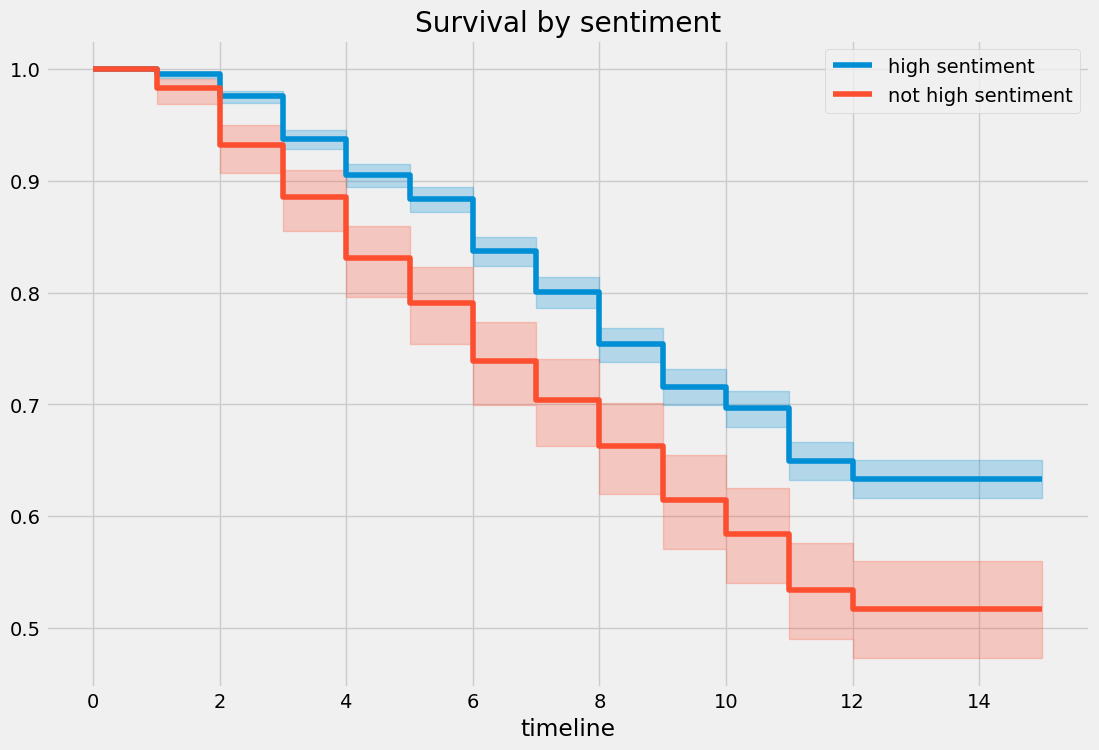

In [24]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

t = np.linspace(0, 15, 16)
kmf.fit(df[high_sentiment]['month'], event_observed=df[high_sentiment]['left'], label='high sentiment', timeline=t)
kmf.plot_survival_function(ax=ax)

kmf.fit(df[~high_sentiment]['month'], event_observed=df[~high_sentiment]['left'], label='not high sentiment', timeline=t)
kmf.plot_survival_function(ax=ax)

plt.title('Survival by sentiment')

In [26]:
results = logrank_test(df[high_sentiment]['month'], df[~high_sentiment]['month'], df[high_sentiment]['left'], df[~high_sentiment]['left'], alpha=0.99, )

In [27]:
# The difference is statistically significant according to the log rank test
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          32.63 <0.005     26.42

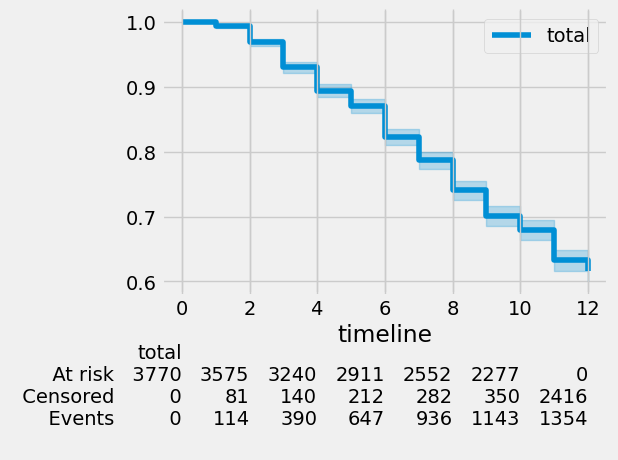

In [29]:
kmf = KaplanMeierFitter().fit(df['month'], df['left'], label='total')
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout()

In [39]:
cox = CoxPHFitter()

In [40]:
df.head()

,gender,field,level,sentiment,intention,left,month
0,M,Public/Government,High,3,8,1,1
1,F,Finance,Low,8,4,0,12
2,M,Education and Training,Medium,7,7,1,5
3,M,Finance,Low,8,4,0,12
4,M,Finance,High,7,6,1,1


In [41]:
cox = cox.fit(df=df, duration_col='month', event_col='left', formula="sentiment + C(gender) + C(level) + C(field)")

In [42]:
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 3770 total observations, 2416 right-censored observations>
             duration col = 'month'
                event col = 'left'
      baseline estimation = breslow
   number of observations = 3770
number of events observed = 1354
   partial log-likelihood = -10724.52
         time fit was run = 2023-05-21 19:25:07 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
C(field)[T.Finance]             0.22       1.25       0.07             0.09             0.35                 1.10                 1.43
C(field)[T.Health]              0.28       1.32       0.13             0.03             0.53                 1.03                 1.70
C(field)[T.Law]                 0.11       1.11       0.15            -0.18             0.39                 0.84                 1.48
C(field)[T.Public/Government]   0.11       1.12       0.09            -0.06             0.29                 0.94                 1.34
C(field)[T.Sales/Marketing]     0.09       1.09       0.10            -0.11             0.29                 0.89                 1.33
C(gender)[T.M]                 -0.05       0.96       0.06            -0.16             0.07                 0.85                 1.07
C(level)[T.Low]                 0.15       1.16       0.09            -0.03             0.32                 0.97                 1.38
C(level)[T.Medium]              0.18       1.19       0.10            -0.02             0.38                 0.98                 1.46
sentiment                      -0.12       0.89       0.01            -0.14            -0.09                 0.87                 0.91

                                cmp to     z      p   -log2(p)
covariate                                                     
C(field)[T.Finance]               0.00  3.34 <0.005      10.24
C(field)[T.Health]                0.00  2.16   0.03       5.02
C(field)[T.Law]                   0.00  0.73   0.47       1.10
C(field)[T.Public/Government]     0.00  1.29   0.20       2.35
C(field)[T.Sales/Marketing]       0.00  0.86   0.39       1.36
C(gender)[T.M]                    0.00 -0.77   0.44       1.19
C(level)[T.Low]                   0.00  1.65   0.10       3.32
C(level)[T.Medium]                0.00  1.73   0.08       3.58
sentiment                         0.00 -8.41 <0.005      54.49
---
Concordance = 0.58
Partial AIC = 21467.04
log-likelihood ratio test = 89.18 on 9 df
-log2(p) of ll-ratio test = 48.58